### Notebook for running SONATA on t_branch dataset
Below, we replicate our results for t_branch dataset reported in *SONATA: Disambiguated manifold alignment of single-cell data.*




In [1]:
import os
import yaml

import sys
sys.path.insert(1, '../src/')
import sonata
from run_baselines.scot import scotv1
from utils.utils import *
from utils.vis import *

In [2]:
# load parameters and datasets
with open("./cfgs/t_branch.yaml", "r") as file:
        params = yaml.safe_load(file)
        
data_url1 = os.path.join(params["data_path"], params["data_url1"])
data_url2 = os.path.join(params["data_path"], params["data_url2"])
assert os.path.isfile(data_url1) and os.path.isfile(data_url2)

label_url1 = os.path.join(params["data_path"], params["label_url1"])
label_url2 = os.path.join(params["data_path"], params["label_url2"])
assert os.path.isfile(label_url1) and os.path.isfile(label_url2)

data1 = load_data(data_url1, )
data2 = load_data(data_url2, )
print("data size: data1 = {}, data2 = {}".format(data1.shape, data2.shape))

label1 = load_data(label_url1, ).astype(int)
label2 = load_data(label_url2, ).astype(int)

# create links for FOSCTTM, all datasets follow 1-1 correspondence
links = np.array(list(zip([i for i in range(data1.shape[0])], [i for i in range(data2.shape[0])])))

save_path = params["save_dir"]
print("data1 shape={}\tdata2 shape={}".format(data1.shape, data2.shape))
print("label1 shape={}\tlabel2 shape={}".format(label1.shape, label2.shape))


data size: data1 = (300, 1000), data2 = (300, 2000)
data1 shape=(300, 1000)	data2 shape=(300, 2000)
label1 shape=(300,)	label2 shape=(300,)


### 1. visualize two modalities

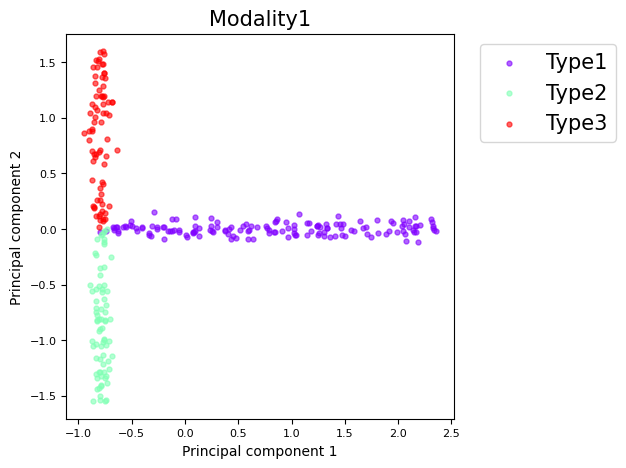

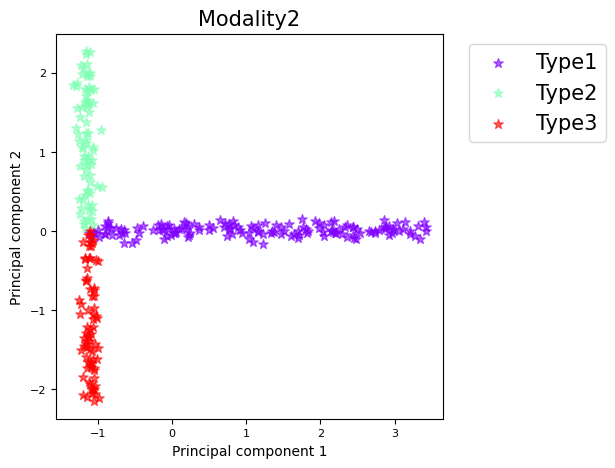

In [3]:
plt_domain_by_labels(data1, label1, title='Modality1', marker='.', a=0.6, show=True)
plt_domain_by_labels(data2, label2, title='Modality2', marker='*', a=0.6, show=True)

### 2. SONATA Diagnose

In [4]:
sn = sonata.sonata(params)
ambiguous_labels, ambiguous_idx = sn.diagnose(data1)

/Users/h46zhou/Documents/anaconda3/envs/sonata_public/lib/python3.8/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


---------------Coupling Denoising Iter=0--------------
Load_path = ../results/sonata_pipeline/t_branch/coupling_iters/coupling_iter0.txt
---------------Coupling Denoising Iter=1--------------
Load_path = ../results/sonata_pipeline/t_branch/coupling_iters/coupling_iter1.txt
---------------Coupling Denoising Iter=2--------------
Load_path = ../results/sonata_pipeline/t_branch/coupling_iters/coupling_iter2.txt
---------------Coupling Denoising Iter=3--------------
Load_path = ../results/sonata_pipeline/t_branch/coupling_iters/coupling_iter3.txt
---------------Coupling Denoising Iter=4--------------
Load_path = ../results/sonata_pipeline/t_branch/coupling_iters/coupling_iter4.txt
---------------Coupling Denoising Iter=5--------------
Load_path = ../results/sonata_pipeline/t_branch/coupling_iters/coupling_iter5.txt
---------------Coupling Denoising Iter=6--------------
Load_path = ../results/sonata_pipeline/t_branch/coupling_iters/coupling_iter6.txt
---------------Coupling Denoising Iter=7-

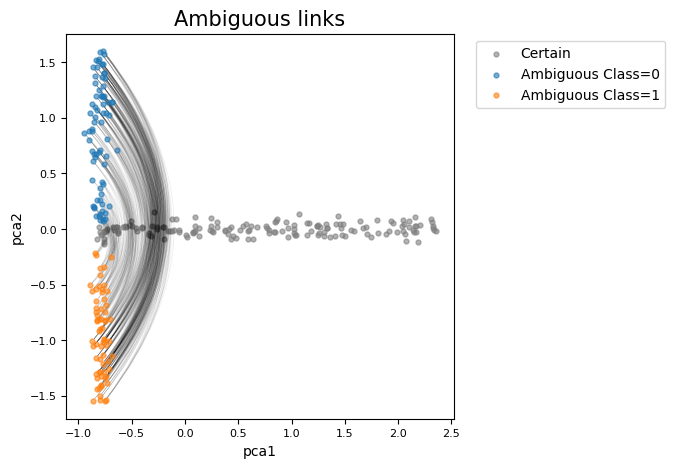

In [5]:
plt_cannotlink_by_labelcolor(data1, ambiguous_idx, ambiguous_labels, sn.cannot_links, alpha=0.6, cl_alpha = 0.1, marker='.',
                                curve_link=True, show=True)

### 3. Mapping by SCOT v1 (or any other manifold aligners)

It.  |Err         
-------------------
    0|7.905339e-03|


/Users/h46zhou/Documents/anaconda3/envs/sonata_public/lib/python3.8/site-packages/ot/bregman/_sinkhorn.py:531: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


   10|5.865960e-12|


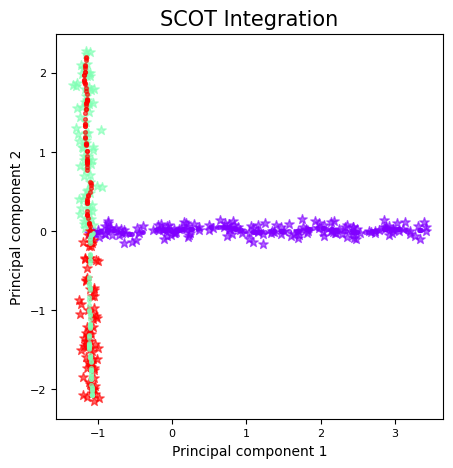

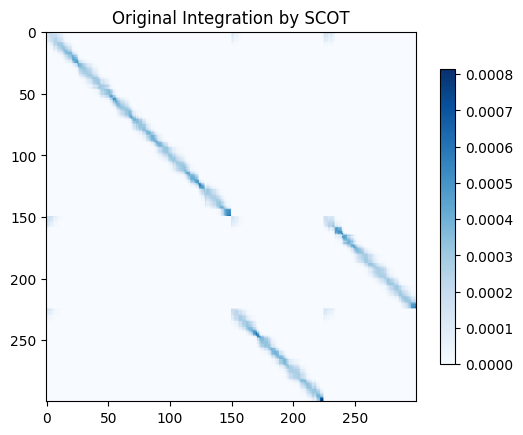

In [6]:
scot = scotv1.SCOT(data1.copy(), data2.copy())
x_aligned, y_aligned = scot.align(k = params["scot_k"], e=params["scot_e"], mode=params["scot_mode"], metric=params["scot_metric"], normalize=params["norm"])
mapping = scot.coupling
plt_mapping_by_labels(x_aligned, y_aligned, label1, label2, title = "SCOT Integration", a = 0.6, show=True)   
plt_heatmap(mapping, title="Original Integration by SCOT", show=True)

#### 4. SONATA Corrects the Ambiguous Alignment

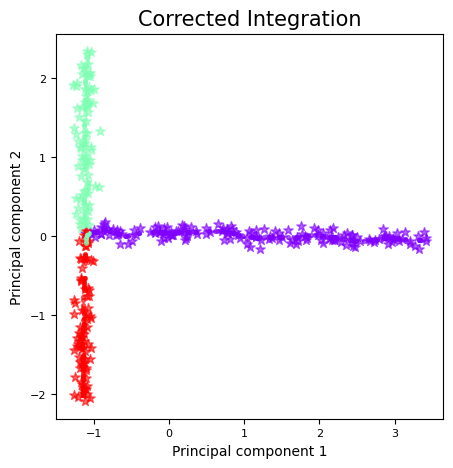

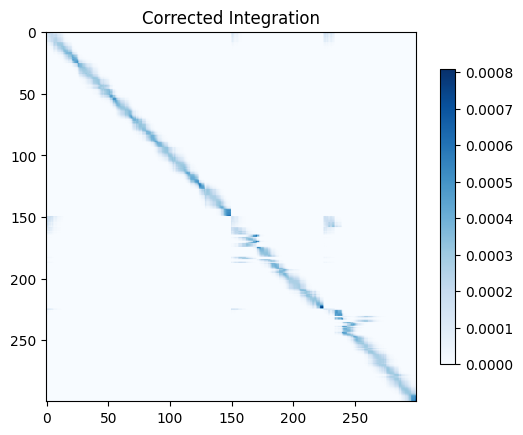

In [7]:
geo_mat1 = geodistance(data1)
alter_mappings = sonata.map_ambiguous_groups(data1, geo_mat1, ambiguous_labels, ambiguous_idx)
for idx, m in enumerate(alter_mappings, start=1):
    this_mapping = np.matmul(m, mapping)
    x_aligned = np.matmul(m, x_aligned)
    y_aligned = y_aligned
    plt_mapping_by_labels(x_aligned, y_aligned, label1, label2, title = "Corrected Integration", a = 0.6, show=True)   
    plt_heatmap(this_mapping, title="Corrected Integration", show=True)